## Ansatze and variational forms

At the heart of all variational algorithms is the key idea of analyzing the differences between states, conveniently related through some well behaved mapping (e.g. continuous, differentiable) from a set of parameters or _variables_ — hence the name. 

First, we'll explore how to construct parametrized circuits by hand. We'll use parametrized circuits define a *variational form* to represent a collection of parametrized states for our variational algorithm to explore. Then, we'll construct our *ansatz* by applying this variational form onto our reference state.

We'll also explore how to tradeoff speed vs accuracy while exploring this search space.

![Ansatz Workflow](images/ansatz_workflow.png)

## Parameterized Quantum Circuits

Variational algorithms work by exploring and comparing a range of _quantum states_ $|\psi(\vec{\theta})\rangle$, depending on a (finite) set of $k$ parameters $\vec{\theta} = (\theta^0,...,\theta^{k-1})$. We can prepare these states with a _parametrized_ quantum circuit, where gates are defined with tunable parameters. We can prepare this parametrized circuit without having to bind specific angles yet:

In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0,1)
qc.x(2)

qc.draw("mpl")

In [ ]:
from math import pi

angle_list = [pi/3, pi/2]
circuits = [qc.bind_parameters({theta: angle}) for angle in angle_list]

for circuit in circuits:
    display(circuit.draw("mpl"))

## Variational Form and Ansatz

To begin iteratively optimizing from our reference state $|\rho\rangle$ to the target state $|\psi(\vec\theta)\rangle$, we must define a *variational form* $U_V(\vec\theta)$ to represent a collection of parametrized states for our variational algorithm to explore:

$$
\begin{aligned}
|0\rangle \xrightarrow{U_R} U_R|0\rangle

& = |\rho\rangle \xrightarrow{U_V(\vec{\theta})} U_A(\vec{\theta})|0\rangle \\[1mm]

& = U_V(\vec{\theta})U_R|0\rangle \\[1mm]

& = U_V(\vec{\theta})|\rho\rangle \\[1mm]

& = |\psi(\vec{\theta})\rangle \\[1mm]

\end{aligned}
$$

Notice that the parametrized state depends both on the reference state $|\rho\rangle$, which does not depend on any parameters, as well as on the variational form $U_V(\vec{\theta})$, which always depends on parameters. We call the combination of these two halves an _ansatz_: $U_A(\vec\theta) := U_V(\vec\theta)U_R$.

As we construct our ansatz to represent a collection of parametrized states for our variational algorithm to explore, we'll realise an important issue: dimensionality. An $n$-qubit system (i.e. _Hilbert space_) has a vast amount of distinct quantum states in the configuration space. We would require an unwieldy large number of parameters to fully explore it. Quantitatively, its dimensionality is $D = 2^{2n}$. To make matters worse, the runtime complexity of search algorithms —and others alike— grows exponentially with this dimensionality, a phenomenon often referred to in the literature as the _curse of dimensionality_.

To counter this setback, it is common practice to impose some (reasonable) constraints on the variational form such that only the most relevant states are explored. Finding efficient truncated ansatz is an active area of research, but we'll cover two common designs.

## Heuristic ansatze and tradeoffs

If you don't have any information about your particular problem that can help restrict the dimensionality, you can try an arbitrary family of parameterized circuits with less than $2^{2n}$ parameters. We have a few tradeoffs to note:

- **Speed**: This will reduce the search space
- **Accuracy**: Reducing the space could risk excluding the actual solution to the problem, leading to suboptimal solutions
- **Noise**: Deeper circuits are affected by noise and we need to experiment with our ansatz's connectivity, gates, gate fidelity

There is a fundamental tradeoff between quality (or even solvability) and speed: the more parameters, the more likely you are to find a precise result, but the longer it will take to run the algorithm.

### N-local circuits

One of the most widely used examples of heuristic ansatze are the [N-local circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits), due to a few reasons:

- **Efficient implementation**: The N-local ansatz is typically composed of simple, local gates that can be implemented efficiently on a quantum computer, using a small number of physical qubits. This makes it easier to construct and optimize quantum circuits.
- **Captures important correlations**: The N-local ansatz can capture important correlations between the qubits in a quantum system, even with a small number of gates. This is because the local gates can act on neighboring qubits and create entanglement between them, which can be important for simulating complex quantum systems.

These circuits consist of rotation and entanglement layers that are repeated alternatively one or more times as follows:

- Each layer is formed by gates of size at most $N$, where $N$ has to be lower than the number of qubits.
- For a rotation layer, the gates are stacked on top of each other. We can use standard rotation operations, such as [`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) or [`CRZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CRZGate.html)
- For an entanglement layer, we can use gates like [`Toffoli` gates](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CCXGate.html) or [`CX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html#qiskit.circuit.library.CXGate) with an entanglement strategy.
- Both types of layers can be parameterized or not, but at least one of them needs to contain parameters. Otherwise, without at least one parameter, there wouldn't be any *variations*!
- Optionally, an extra rotation layer is added to the end of the circuit.

For example, let's create a $5$-qubit [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) circuit with rotation blocks formed by [`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) and [`CRZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CRZGate.html) gates, entanglement blocks formed by [`Toffoli` gates](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CCXGate.html) that act on qubits $[0,1,2]$, $[0,2,3]$, $[4,2,1]$ and $[3,1,0]$ and $2$ repetitions of each layer.

In [ ]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter('θ')
ansatz = NLocal(num_qubits=5, rotation_blocks=[RXGate(theta), CRZGate(theta)], entanglement_blocks=CCXGate(), entanglement=[[0,1,2],[0,2,3],[4,2,1],[3,1,0]], reps=2, insert_barriers=True)
ansatz.decompose().draw("mpl")

In the above example, the biggest gate in this case is the Toffoli, acting on $3$ qubits. That means this circuit is $3$-local. The most common type of $N$-local circuits are [2-local](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) with single-qubit rotation gates and $2$-qubit entanglement gates. 

Let's create a $2$-local circuit with Qiskit's [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) class. The syntax is the same as `NLocal`'s but there are some differences. For instance, most gates, like the [`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) and [`RZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html) and [`CNOT` (`CX`)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html) can be passed as strings without importing the gates or creating a [`Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) instance.

In [ ]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(num_qubits = 5, rotation_blocks=['rx', 'rz'], entanglement_blocks='cx', entanglement="linear", reps=2, insert_barriers=True)
ansatz.decompose().draw("mpl")

In this case we used the `linear` entanglement distribution, where each qubit is entangled with the next. For other default strategies, check [the documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html).

### EfficientSU2

[`EfficientSU2`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) is a hardware-efficient circuit consists of layers of single qubit operations spanned by SU(2) and $CX$ entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or classification circuit for machine learning.

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=['rx', 'y'], entanglement='linear', reps=1)
ansatz.decompose().draw('mpl')

## Problem-specific ansatze

While heuristic and hardware efificent ansatze help us naively solve a problem, we can use problem-specific knowledge to help restrict our circuit search space to a specific type. This will help gain speed without losing accuracy in our search process.

### Quantum Chemistry

A typical application in chemistry is finding the ground state of a particular molecular system. The [_Unitary Coupled-Cluster (UCC)_](https://qiskit.org/ecosystem/nature/stubs/qiskit_nature.second_q.circuit.library.UCC.html) ansatz was originally proposed to add variational bounds to the ground state exploration, and improving the speed while exploring the search space. In the following example, we're demonstrating using a Hartree-Fock approximation as our reference state, and then leveraging the Unitary Coupled-Cluster with double excitations from the Hartree-Fock ground state.

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

h2_problem = driver.run()

converter = QubitConverter(JordanWignerMapper())

h2_reference_state = HartreeFock(
    h2_problem.num_spatial_orbitals,
    h2_problem.num_particles,
    converter
)

ansatz = UCC(
    h2_problem.num_spatial_orbitals,
    h2_problem.num_particles,
    converter,
    initial_state=h2_reference_state,
    excitations=2
)

ansatz.decompose().decompose().draw('mpl')

### Quantum Machine Learning 

In Machine Learning, a typical application is [classifying data into two or more categories](https://learn.qiskit.org/course/machine-learning/variational-classification). This includes [encoding a datapoint](https://learn.qiskit.org/course/machine-learning/data-encoding) into a feature map that maps classical feature vectors into the quantum Hilbert space. Constructing quantum feature maps based on parameterized quantum circuits that are hard to simulate classically is an important step towards possibly obtaining an advantage over classical machine learning approaches, and is an active area of current research.

We can use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) to create a parameterized circuit. We can use pass in our data points to the feature map ($x$), and a separate variational form to pass in weights as parameters ($\theta$).

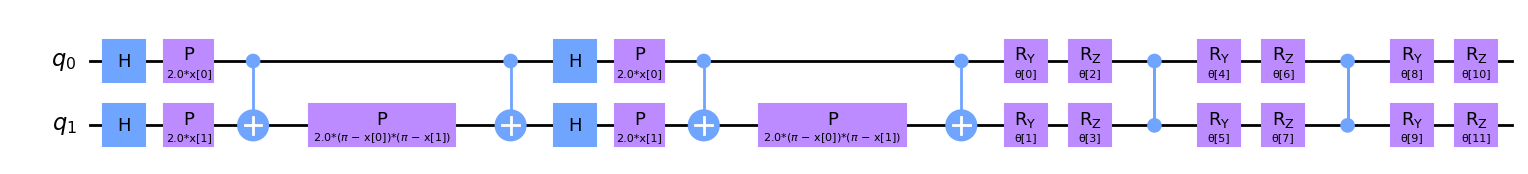

In [12]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference.bind_parameters(data)
zz_feature_map_reference.decompose().draw('mpl')


variation_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)
vqc_ansatz = zz_feature_map_reference.compose(variation_form)
vqc_ansatz.decompose().draw('mpl')

With this lesson, you learned how to define your search space with a variational form:

- Prepare states with a _parametrized_ quantum circuit, where gates are defined with tunable parameters.
- How to construct ansatze that tradeoff speed vs accuracy
- Heuristic ansatze 
- Problem-specific ansatze

Our high-level variational workload looks as follows:

![Ansatz Circuit](images/ansatz_circuit.png)

For each variational parameter $\vec\theta$, a different quantum state will be produced. To find the optimial parameters, we need to define a problem-specific _cost function_ to iteratively update our ansatz's parameters.